# Fetch and load PDB
This code acquires the pdb file from the RCSB databank, loads the necessary information, and saves copies for possible use in visualization in other software.

In [1]:
from pyCapsid.PDB import getCapsid
pdb = '4oq8'
capsid, calphas, coords, bfactors, chain_starts, title = getCapsid(pdb)

Fetching file 1 / 1 (4oq8)...
Done
Number of protein chains: 60
# of residues: 8640


# Build ENM Hessian
This code builds a hessian matrix using an elastic network model defined by the given parameters. The types of model and the meaning of the parameters are provided in the documentation.

In [2]:
from pyCapsid.CG import buildENMPreset
kirch, hessian = buildENMPreset(coords, preset='U-ENM')

Building hessian for model preset:  U-ENM
Model parameters:  {'cutoff': 7.5, 'gnm': False, 'fanm': 0.1, 'wfunc': 'power', 'base_dist': 1, 'd_power': 0, 'backbone': False, 'k_backbone': 1, 'l_backbone': 1, 'chain_starts': None, 'save_hessian': False, 'save_kirchhoff': False, 'save_cg_path': './'}
Finding neighbors within 7.5Å
Building kirchhoff matrix
Building hessian matrix
Done building model


# Perform NMA
## Calculate low frequency modes
This code calculates the n lowest frequency modes of the system by calculating the eigenvalues and eigenvectors of the hessian matrix.

In [3]:
from pyCapsid.NMA import modeCalc
evals, evecs = modeCalc(hessian)

Calculating Normal Modes
Using shift-invert for increased performance with increased memory usage.
NMA time:  21.667727599968202
Saving NMA results in./modes.npz


## Predict, fit, and compare b-factors
This code uses the resulting normal modes and frequencies to predict the b-factors of each alpha carbon, fits these results to experimental values from the pdb entry, and plots the results for comparison.

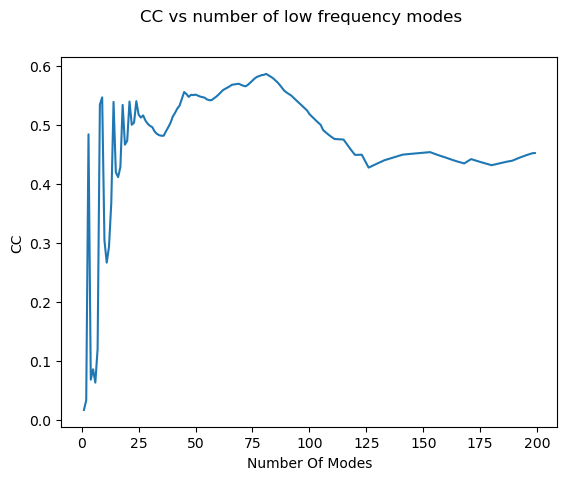

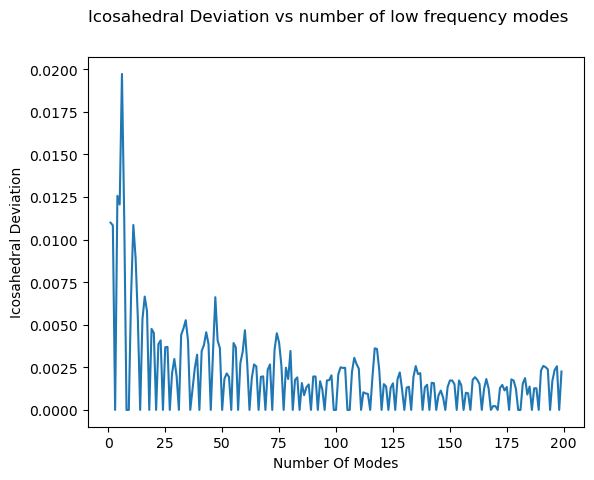

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 8640
Model:                            RLM   Df Residuals:                     8639
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 17 Jun 2023                                         
Time:                        18:02:57                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           146.9902      0.103   1422.855      0.0

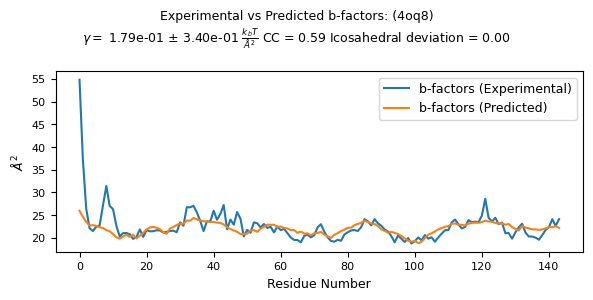

bfactor fitting time:  1.827301500015892


In [4]:
from pyCapsid.NMA import fitCompareBfactors
evals_scaled, evecs_scaled = fitCompareBfactors(evals, evecs, bfactors, pdb)

# Perform quasi-rigid cluster identification (QRC)

Calculating sparse covariance matrix
Calculating sparse distance fluctuation matrix from covariance matrix
Performing Spectral Embedding
Clustering Embedded Points
Method: discretize


C:\Users\colin\miniconda3\envs\pycaplocal\lib\site-packages\pyCapsid\clustering_util.py:94: RuntimeWarning: divide by zero encountered in divide
  s = a / b


QRC time:  8.317528499988839
Plotting


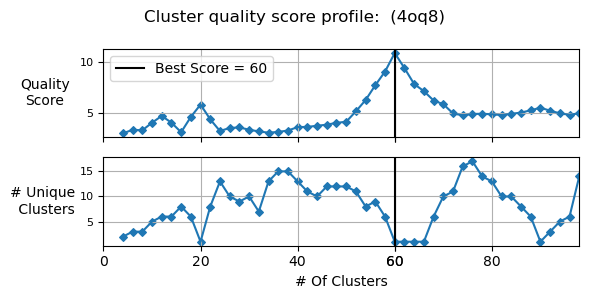

In [5]:
from pyCapsid.NMA import calcDistFlucts
from pyCapsid.QRC import findQuasiRigidClusters

dist_flucts = calcDistFlucts(evals_scaled, evecs_scaled, coords)

cluster_start = 4
cluster_stop = 100
cluster_step = 2
labels, score, residue_scores  = findQuasiRigidClusters(pdb, dist_flucts, cluster_start=cluster_start, cluster_stop=cluster_stop, cluster_step=cluster_step)

## Visualize in jupyter notebook with nglview
You can visualize the results in the notebook with nglview. The following function returns an nglview object with the results colored based on cluster. See the nglview documentation for further info (http://nglviewer.org/nglview/release/v2.7.7/index.html)

In [ ]:
# This cell will create an standard view of the capsid, which the next cell will 
# modify to create the final result.
from pyCapsid.VIS import createCapsidView
view_clusters = createCapsidView(pdb, capsid)
view_clusters

In [ ]:
# If the above view doesn't change coloration, run this cell again.
# In general do not run this cell until the above cell has finished rendering
from pyCapsid.VIS import createClusterRepresentation
createClusterRepresentation(pdb, labels, view_clusters)

# Add rep_type='spacefill' to represent the atoms of the capsid as spheres. This provides less information regarding the proteins but makes it easier to identify the geometry of the clusters
#createClusterRepresentation(pdb, labels, view_clusters, rep_type='spacefill')

In [ ]:
# Once you've done this use this code to download the results
view_clusters.center()
view_clusters.download_image(factor=2)

Running the same code but replacing labels with residue_scores and adding rwb_scale=True visualizes the quality score of each residue. This is a measure of how rigid each residue is with respect to its cluster. Blue residues make up the cores of rigid clusters, and red residues represent borders between clusters. 

In [ ]:
# This code adds a colorbar based on the residue scores
print('Each atom in this structure is colored according to the clustering quality score of its residue.')
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
from pyCapsid.VIS import clusters_colormap_hexcolor
import numpy as np
hexcolor, cmap = clusters_colormap_hexcolor(residue_scores, rwb_scale=True)
fig, ax = plt.subplots(figsize=(10, 0.5))
cb = colorbar.ColorbarBase(ax, orientation='horizontal',
                            cmap=cmap, norm=plt.Normalize(np.min(residue_scores), np.max(residue_scores)))
plt.show()

# This cell will create an empty view, which the next cell will 
# modify to create the final result.
from pyCapsid.VIS import createCapsidView
view_scores = createCapsidView(pdb, capsid)
view_scores

In [ ]:
from pyCapsid.VIS import createClusterRepresentation
createClusterRepresentation(pdb, residue_scores, view_scores, rwb_scale=True)

In [ ]:
# Once you've done this use this code to download the results
view_scores.center()
view_scores.download_image(factor=2)

## Visualize in ChimeraX
If ChimeraX (https://www.cgl.ucsf.edu/chimerax/download.html) is installed you may provide a path to the chimerax executable file to automatically visualize the results in chimerax. This is done using the runscript command in chimerax and this python script: (https://github.com/luquelab/pyCapsid/blob/main/src/pyCapsid/scripts/chimerax_script.py).

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pyCapsid.VIS import chimeraxViz
chimeraxViz(labels, pdb, chimerax_path='C:\\Program Files\\ChimeraX\\bin\\ChimeraX.exe')

C:/Users/colin/AppData/Local/Temp/tmp_pr3l5re.npy
""C:\Program Files\ChimeraX\bin\ChimeraX.exe" --script "C:\Users\colin\miniconda3\envs\pycaplocal\lib\site-packages\pyCapsid\scripts\chimerax_script.py C:/Users/colin/AppData/Local/Temp/tmp_pr3l5re.npy . . True 4oq8 False""


Running the same code but replacing labels with residue_scores and adding rwb_scale=True visualizes the quality score of each residue. This is a measure of how rigid each residue is with respec to its cluster. Blue residues make up the cores of rigid clusters, and red residues represent borders between clusters. 

In [ ]:
from pyCapsid.VIS import chimeraxViz
chimeraxViz(residue_scores, pdb, chimerax_path='C:\\Program Files\\ChimeraX\\bin\\chimerax.exe', rwb_scale=True)

# Visualizing saved results
The numerical results are saved as compressed .npz files by default and can be opened and used to visualize the results afterwards. This includes the ability to visualize clusters that weren't the highest scoring cluster. In this example
we visualize the results of clustering the capsid into 20 clusters.

In [ ]:
from pyCapsid.VIS import visualizeSavedResults
results_file = f'{pdb}_final_results_full.npz' # Path of the saved results
labels_20, view_clusters = visualizeSavedResults(pdb, results_file, n_cluster=20, method='nglview')
view_clusters

In [ ]:
# If the above view doesn't change coloration, run this cell again.
# In general do not run this cell until the above cell has finished rendering
from pyCapsid.VIS import createClusterRepresentation
createClusterRepresentation(pdb, labels_20, view_clusters)

# Add rep_type='spacefill' to represent the atoms of the capsid as spheres. This provides less information regarding the proteins but makes it easier to identify the geometry of the clusters
#createClusterRepresentation(pdb, labels, view_clusters, rep_type='spacefill')

In Chimerax

In [ ]:
visualizeSavedResults(pdb, results_file, n_cluster=20, method='chimerax')